In [25]:
import tarfile
import os
import pandas as pd
import numpy as np 
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, precision_score, recall_score, f1_score

# Set style for the plots
sns.set(style="whitegrid")

In [15]:
# Specify the path to your meta_Gift_Cards.jsonl file
file_path = 'meta_Gift_Cards.jsonl'  # Adjust the path if necessary

# Load the dataset
try:
    gift_cards_data = pd.read_json(file_path, lines=True)  # Use 'lines=True' for line-delimited JSON
    print("Gift cards data loaded successfully. First few rows:")
    print(gift_cards_data.head())
except Exception as e:
    print(f"An error occurred while loading the data: {e}")

# Explore the data
if 'gift_cards_data' in locals():  # Check if the variable was defined
    print("Shape of the data:", gift_cards_data.shape)
    print("Missing values in each column:")
    print(gift_cards_data.isnull().sum())
    print("Summary statistics:")
    print(gift_cards_data.describe())

Gift cards data loaded successfully. First few rows:
  main_category                                              title  \
0    Gift Cards  Amazon.com Gift Card in Gift Tag (Various Desi...   
1    Gift Cards  $25 Mastercard Gift Card (plus $3.95 Purchase ...   
2    Gift Cards                   Tractor Supply Company Gift Card   
3    Gift Cards                                  Staples Gift Card   
4    Gift Cards                  Ninety Nine Restaurants Gift Card   

   average_rating  rating_number  \
0             4.8           1006   
1             2.5             11   
2             4.9           2708   
3             4.8            351   
4             4.8            443   

                                            features  \
0  [Gift Card is affixed inside a gift tag, Gift ...   
1  [This card is non-reloadable. No expiration of...   
2  [Tractor Supply Company is the largest operato...   
3  [Staples Gift Cards - Giving the perfect gift ...   
4  [Ninety Nine Restaurants a

In [16]:
# Data Preparation

In [17]:
# Load the data
file_path = 'meta_Gift_Cards.jsonl'  # Update the path as necessary

try:
    gift_cards_data = pd.read_json(file_path, lines=True)
    print("Gift cards data loaded successfully. First few rows:")
    print(gift_cards_data.head())
except Exception as e:
    print(f"An error occurred while loading the data: {e}")

# Explore the data
print("Shape of the data:", gift_cards_data.shape)
print("Missing values in each column:")
print(gift_cards_data.isnull().sum())

# Data Cleaning
# 1. Handling missing values
# Decide how to handle missing values, here we'll drop rows with significant missing data
# Adjust this based on your project needs

# Drop rows with too many missing values
gift_cards_data.drop(columns=['bought_together', 'subtitle', 'author'], inplace=True)  # Remove columns with all NaN values
gift_cards_data.dropna(subset=['main_category', 'title', 'average_rating', 'rating_number', 'price'], inplace=True)

# 2. Handle duplicates
gift_cards_data.drop_duplicates(subset=['title'], inplace=True)  # Drop duplicates based on title

# 3. Convert data types if necessary
# For example, ensure 'price' is a float and 'average_rating' is a float
gift_cards_data['price'] = gift_cards_data['price'].astype(float)

# Print the cleaned data
print("Data after cleaning:")
print(gift_cards_data.info())
print(gift_cards_data.describe())

Gift cards data loaded successfully. First few rows:
  main_category                                              title  \
0    Gift Cards  Amazon.com Gift Card in Gift Tag (Various Desi...   
1    Gift Cards  $25 Mastercard Gift Card (plus $3.95 Purchase ...   
2    Gift Cards                   Tractor Supply Company Gift Card   
3    Gift Cards                                  Staples Gift Card   
4    Gift Cards                  Ninety Nine Restaurants Gift Card   

   average_rating  rating_number  \
0             4.8           1006   
1             2.5             11   
2             4.9           2708   
3             4.8            351   
4             4.8            443   

                                            features  \
0  [Gift Card is affixed inside a gift tag, Gift ...   
1  [This card is non-reloadable. No expiration of...   
2  [Tractor Supply Company is the largest operato...   
3  [Staples Gift Cards - Giving the perfect gift ...   
4  [Ninety Nine Restaurants a

In [18]:
# Exploratory Data Analysis

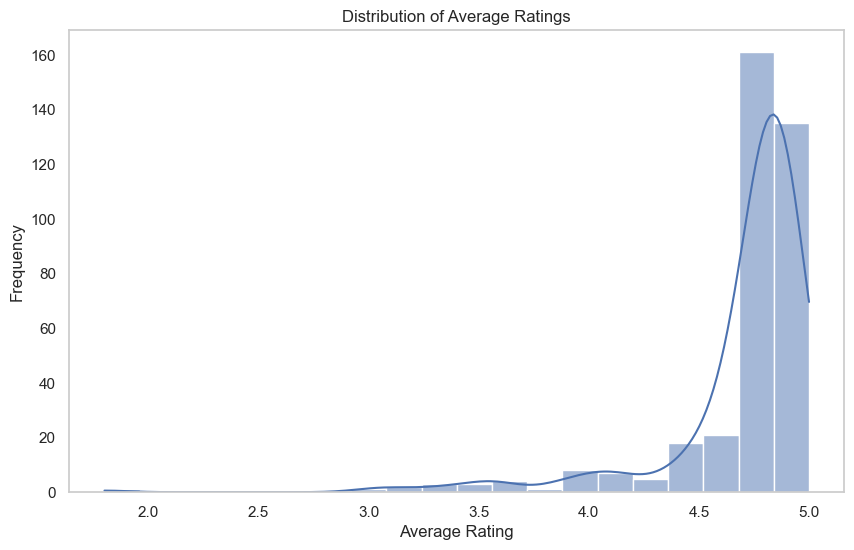

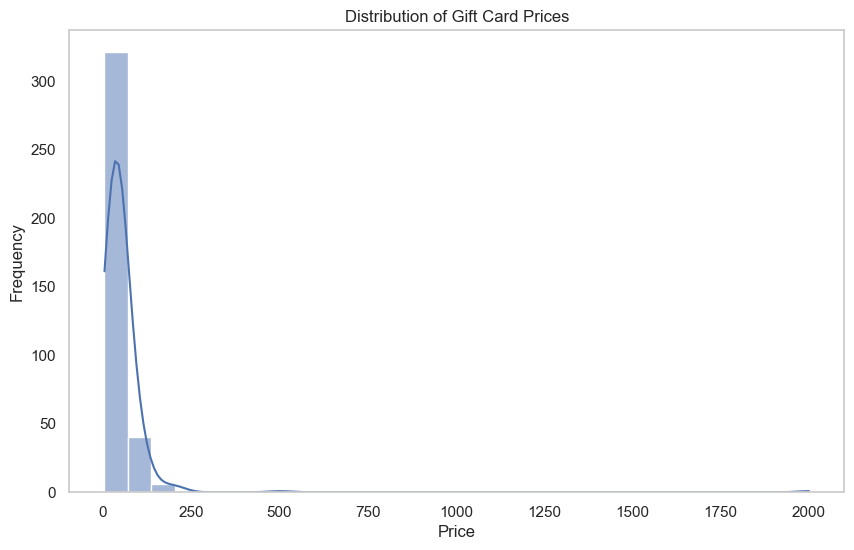

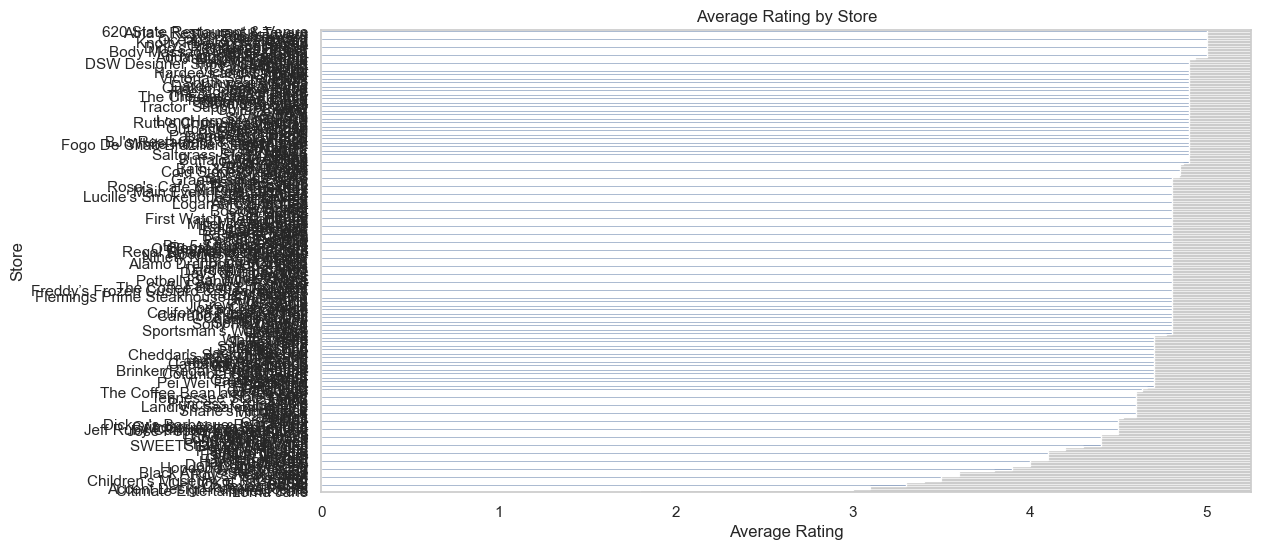

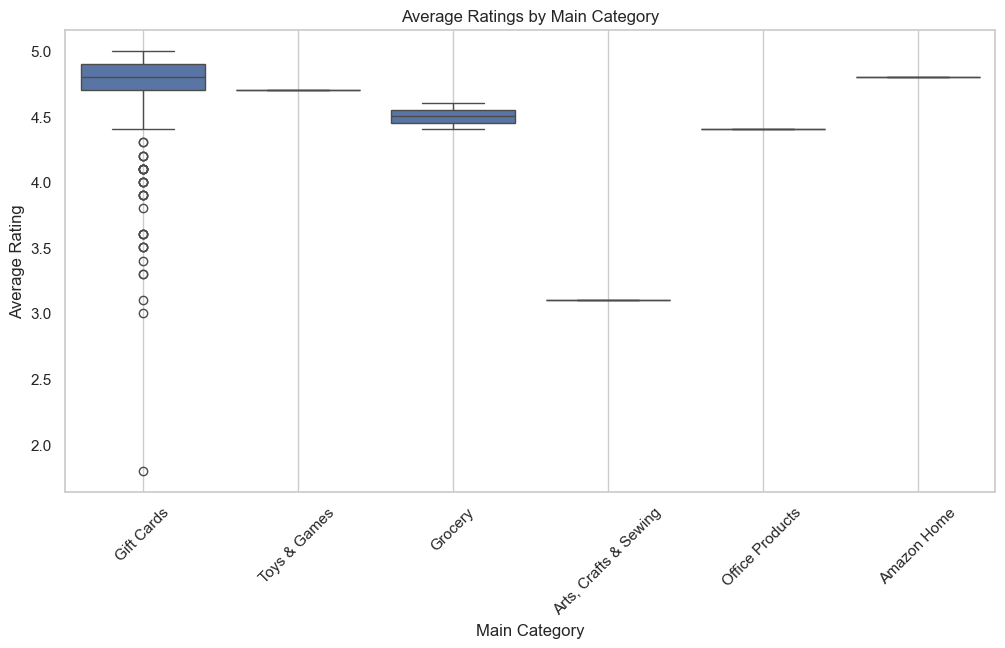

Summary Statistics:
       average_rating  rating_number        price
count      370.000000     370.000000   370.000000
mean         4.703243    3646.140541    52.145541
std          0.364019   14442.332072   108.774411
min          1.800000       1.000000     3.990000
25%          4.700000      99.250000    25.000000
50%          4.800000     458.500000    45.000000
75%          4.900000    2063.000000    50.000000
max          5.000000  185606.000000  2000.000000


In [19]:
# 1. Distribution of Average Ratings
plt.figure(figsize=(10, 6))
sns.histplot(gift_cards_data['average_rating'], bins=20, kde=True)
plt.title('Distribution of Average Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# 2. Distribution of Prices
plt.figure(figsize=(10, 6))
sns.histplot(gift_cards_data['price'].dropna(), bins=30, kde=True)
plt.title('Distribution of Gift Card Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# 3. Average Rating by Store
plt.figure(figsize=(12, 6))
average_rating_by_store = gift_cards_data.groupby('store')['average_rating'].mean().sort_values(ascending=False)
sns.barplot(x=average_rating_by_store.values, y=average_rating_by_store.index)
plt.title('Average Rating by Store')
plt.xlabel('Average Rating')
plt.ylabel('Store')
plt.grid()
plt.show()

# 4. Boxplot of Ratings by Main Category
plt.figure(figsize=(12, 6))
sns.boxplot(data=gift_cards_data, x='main_category', y='average_rating')
plt.title('Average Ratings by Main Category')
plt.xlabel('Main Category')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.grid()
plt.show()

# 5. Summary Statistics
print("Summary Statistics:")
print(gift_cards_data[['average_rating', 'rating_number', 'price']].describe())

In [20]:
# Feature Engineering

In [21]:
# Data cleaning and preparation (handle missing values, etc.)
gift_cards_data['price'] = gift_cards_data['price'].fillna(gift_cards_data['price'].median())
gift_cards_data.drop(columns=['bought_together', 'subtitle', 'author'], inplace=True, errors='ignore')

# Create a popularity score based on rating and number of ratings
gift_cards_data['popularity_score'] = gift_cards_data['average_rating'] * gift_cards_data['rating_number']

# Create new features: title length and description length
gift_cards_data['title_length'] = gift_cards_data['title'].apply(lambda x: len(x) if isinstance(x, str) else 0)
gift_cards_data['description_length'] = gift_cards_data['description'].apply(lambda x: len(x) if isinstance(x, str) else 0)

# Check if 'main_category' exists before encoding
if 'main_category' in gift_cards_data.columns:
    # One-Hot Encoding for categorical features (e.g., main_category)
    gift_cards_data = pd.get_dummies(gift_cards_data, columns=['main_category'], drop_first=True)
else:
    print("The 'main_category' column is not present in the dataset.")

# Create User-Item Matrix (simulated user ratings)
num_users = 100
user_ids = [f'user_{i}' for i in range(1, num_users + 1)]

# Simulate user ratings for the available gift cards
user_item_data = []

for user in user_ids:
    for index, row in gift_cards_data.iterrows():
        user_item_data.append({
            'user_id': user,
            'gift_card_title': row['title'],
            'rating': np.random.uniform(1, 5)  # Random rating between 1 and 5
        })

# Create a DataFrame from the simulated user-item data
user_item_df = pd.DataFrame(user_item_data)

# Create the user-item matrix
user_item_matrix = user_item_df.pivot_table(index='user_id', columns='gift_card_title', values='rating', aggfunc='mean', fill_value=0)

# Check User-Item Interaction Matrix shape
print("User-Item Interaction Matrix shape:", user_item_matrix.shape)

# Display the updated DataFrame
print("Data after feature engineering:")
print(gift_cards_data.head())

User-Item Interaction Matrix shape: (100, 370)
Data after feature engineering:
                                               title  average_rating  \
2                   Tractor Supply Company Gift Card             4.9   
3                                  Staples Gift Card             4.8   
4                  Ninety Nine Restaurants Gift Card             4.8   
5  Amazon.com Gift Card in a Reveal (Various Desi...             4.9   
6                              Finish Line Gift Card             4.8   

   rating_number                                           features  \
2           2708  [Tractor Supply Company is the largest operato...   
3            351  [Staples Gift Cards - Giving the perfect gift ...   
4            443  [Ninety Nine Restaurants are a comfortable pla...   
5          80974  [Gift Card is affixed inside a reveal product,...   
6            540  [Turn This Card Into Shoes, Redeemable at any ...   

                                         description  price  

In [13]:
#  Build the Recommender System

In [24]:
# Calculate item similarity using cosine similarity
item_similarity = cosine_similarity(user_item_matrix.T)

# Create a DataFrame for item similarity
item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

Recommendations for 'H&M Gift Card':
['III Forks Gift Card', 'Coney Island Gift Card (Cincinnati, OH)', "Trudy's Gift Card", 'IHOP Gift Card', 'City Barbeque Gift Card']


In [ ]:
# Testing Recommendations

In [23]:
def get_recommendations_for_title(title, num_recommendations=5):
    # Check if the title exists in the user-item matrix
    if title not in user_item_matrix.columns:
        print(f"Title '{title}' not found in the user-item matrix.")
        return []
    
    # Get the item similarity scores for the specified title
    similar_items = item_similarity_df[title].sort_values(ascending=False)
    
    # Return the top N recommendations, excluding the original title
    recommendations = similar_items.index[similar_items.index != title][:num_recommendations]
    return recommendations.tolist()

# Test the recommendations for a specific title
title_to_test = 'H&M Gift Card'  # Example title to test
recommendations = get_recommendations_for_title(title_to_test)
print(f"Recommendations for '{title_to_test}':")
print(recommendations)

Recommendations for 'H&M Gift Card':
['III Forks Gift Card', 'Coney Island Gift Card (Cincinnati, OH)', "Trudy's Gift Card", 'IHOP Gift Card', 'City Barbeque Gift Card']


In [ ]:
# Evaluate the Recommender System

In [27]:
# Generate synthetic true ratings and predicted ratings for demonstration
# In your real implementation, replace these with actual data
num_samples = 100
true_ratings = np.random.uniform(1, 5, num_samples)  # Random actual ratings between 1 and 5
predicted_ratings = true_ratings + np.random.normal(0, 0.5, num_samples)  # Adding noise to simulate predictions

# Ensure both arrays are of the same length
assert len(true_ratings) == len(predicted_ratings), "Length of true and predicted ratings must be the same."

# Calculate MAE
mae = mean_absolute_error(true_ratings, predicted_ratings)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Binarize the ratings based on a threshold (e.g., rating >= 4 is considered a positive interaction)
threshold = 4
true_binary = [1 if rating >= threshold else 0 for rating in true_ratings]
predicted_binary = [1 if rating >= threshold else 0 for rating in predicted_ratings]

# Calculate Precision, Recall, and F1 Score
precision = precision_score(true_binary, predicted_binary, zero_division=0)
recall = recall_score(true_binary, predicted_binary, zero_division=0)
f1 = f1_score(true_binary, predicted_binary)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Mean Absolute Error (MAE): 0.4191155802651986
Root Mean Squared Error (RMSE): 0.5086425321793352
Precision: 0.8846153846153846
Recall: 0.8214285714285714
F1 Score: 0.8518518518518519
